## PyTorch CEA model

In [1]:
import time
import types
from types import SimpleNamespace as NewObj

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchsummary import summary

from sklearn.utils import shuffle

from logger import TBLogger

%load_ext autoreload
%autoreload 2

In [2]:
debug_vals = NewObj()

In [3]:
TINY = 1e-15

patch_size = 64 # image size = 64 x 64 = 4096
batch_size = 256
emb_size = 3200
conv_emb_size = 50 * 8 * 8

### Load Data

In [4]:
from matplotlib.image import imread
from extract_patches import *

from os import listdir
from os.path import isfile, join

In [5]:
data_path = './data'

# load single file
img_name = 'ESP_011261_1960_RED0_0.IMG'
images, ids = extract_patches_from_img(img_name, patch_size=patch_size)

# get all red files
red_img_files = [f for f in listdir(data_path)
                 if isfile(join(data_path, f)) and 'RED' in f]

len(red_img_files)

/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2575: DecompressionBombWarning: Image size (102400000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


58

In [6]:
len(images)

25008

In [7]:
from pytorch_utils import *

tensor_images = numpy_images_to_tensor_dataset(images)

tensor_images = tensor_images / 255

In [8]:
tensor_images.size(), tensor_images.mean()

(torch.Size([25008, 1, 64, 64]), tensor(0.4481))

In [9]:
try:
    # we need it because of cuda bug:
    # https://github.com/pytorch/pytorch/issues/17108
    _ = torch.cuda.current_device()
except:
    pass

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load saved Model

In [10]:
# just a namespace
class ConvAAE():
    class Encoder(nn.Module):
        def __init__(self, image_channels=1):
            super(ConvAAE.Encoder, self).__init__()
            
            self.encoder = nn.Sequential(
                nn.Conv2d(image_channels, 16, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(),
                
                nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(),
                
                nn.MaxPool2d(2, stride=2),
            
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(),
                
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(),
                
                nn.MaxPool2d(2, stride=2),
                
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(),
                
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(),
                
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(),
                
                nn.MaxPool2d(2, stride=2),
                
                nn.Conv2d(64, 50, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(50),
                nn.LeakyReLU(),
                
                nn.Conv2d(50, 50, kernel_size=3, stride=1, padding=1),
#                 nn.BatchNorm2d(50),
#                 nn.LeakyReLU(),
                
#                 nn.Conv2d(50, 50, kernel_size=3, stride=1, padding=1),
#                 nn.BatchNorm2d(50),
#                 nn.LeakyReLU(),
                
#                 nn.MaxPool2d(2, stride=2),
            
                Flatten()
            )

        def forward(self, input_data):
            # generate embeddings for our images
            embeddings = self.encoder(input_data)

            return embeddings

        
    class Decoder(nn.Module):
        def __init__(self, image_channels=1):
            super(ConvAAE.Decoder, self).__init__()
            
            self.decoder = nn.Sequential(
                Unflatten(C=50, H=8, W=8),

                # upsampling + conv
                nn.ConvTranspose2d(50, 64, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(),
                
                nn.Conv2d(64, 64, 3, 1, 1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(),
                
                nn.Conv2d(64, 64, 3, 1, 1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(),

                # upsampling + conv
                nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(),
                
                nn.Conv2d(32, 32, 3, 1, 1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(),
                
                nn.Conv2d(32, 32, 3, 1, 1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(),

                # upsampling + conv
                nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(),
                
                nn.Conv2d(16, 16, 3, 1, 1),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(),
                
#                 # upsampling + conv
#                 nn.ConvTranspose2d(16, 16, kernel_size=4, stride=2, padding=1),
#                 nn.BatchNorm2d(16),
#                 nn.LeakyReLU(),
                
#                 nn.Conv2d(16, 16, 3, 1, 1),
#                 nn.BatchNorm2d(16),
#                 nn.LeakyReLU(),

                nn.Conv2d(16, image_channels, 3, 1, 1),
            )


        def forward(self, input_embeddings):
            data = self.decoder(input_embeddings)
            
            return data

    class Discriminator(nn.Module):
        def __init__(self, image_channels=1):
            super(ConvAAE.Discriminator, self).__init__()

            self.discriminator = nn.Sequential(
                nn.Linear(emb_size, 30),
                nn.LeakyReLU(),
                
                nn.Linear(30, 10),
                nn.LeakyReLU(),

                # linear layer with 1 element
                nn.Linear(10, 1),

                nn.Sigmoid()
            )

        def forward(self, input_embeddings):
            # process embeddings and guess if it's real or fake
            discriminator_output = self.discriminator(input_embeddings)

            return discriminator_output

print('    ENCODER')
summary(ConvAAE.Encoder().to(device), (1, patch_size, patch_size))

print('\n\n    DECODER')
summary(ConvAAE.Decoder().to(device), (1, emb_size))

print('\n\n    DISCRIMINATOR')
summary(ConvAAE.Discriminator().to(device), (1, emb_size))

    ENCODER
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             160
       BatchNorm2d-2           [-1, 16, 64, 64]              32
         LeakyReLU-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 16, 64, 64]           2,320
       BatchNorm2d-5           [-1, 16, 64, 64]              32
         LeakyReLU-6           [-1, 16, 64, 64]               0
         MaxPool2d-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           4,640
       BatchNorm2d-9           [-1, 32, 32, 32]              64
        LeakyReLU-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           9,248
      BatchNorm2d-12           [-1, 32, 32, 32]              64
        LeakyReLU-13           [-1, 32, 32, 32]               0
        MaxPool2d-14       

In [11]:
def reset_model():
    global encoder_net, decoder_net, discrim_net

    # creating sub-models
    encoder_net = ConvAAE.Encoder().to(device)
    decoder_net = ConvAAE.Decoder().to(device)
    discrim_net = ConvAAE.Discriminator().to(device)

reset_model()

In [12]:
models_folder = './logs/added adversarial component 20-19-48/models/'
target_epoch = 235

reset_model()

encoder_net.load_state_dict(torch.load(models_folder + f'encoder_net_e_{target_epoch}.pth'))
decoder_net.load_state_dict(torch.load(models_folder + f'decoder_net_e_{target_epoch}.pth'))
discrim_net.load_state_dict(torch.load(models_folder + f'discrim_net_e_{target_epoch}.pth'))

_ = encoder_net.eval(), decoder_net.eval(), discrim_net.eval()

### Test

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_img_grid(images, grid_size=6):
    images = images[:grid_size ** 2]
    
    fig, img_plots = plt.subplots(grid_size, grid_size, figsize=(8, 8), gridspec_kw = {'wspace':0.01, 'hspace':0.01})

    fig.patch.set_facecolor('black')

    for i in range(0, grid_size):
        for j in range(0, grid_size):
            img_plt = img_plots[i, j]

            img = images[i * grid_size + j]
            img_plt.imshow(np.squeeze(img), cmap='gray', vmin=0, vmax=1)
            img_plt.axis('off')

    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    

In [14]:
def predict(images):
    test_data = images.to(device)

    # forward
    embeddings = encoder_net(test_data)
    test_output = decoder_net(embeddings)
    
    return embeddings.data.cpu().numpy(), test_output.data.cpu().numpy()


def predict_and_print(images):
    embeddings, predicted_images = predict(images)

    show_img_grid(predicted_images)


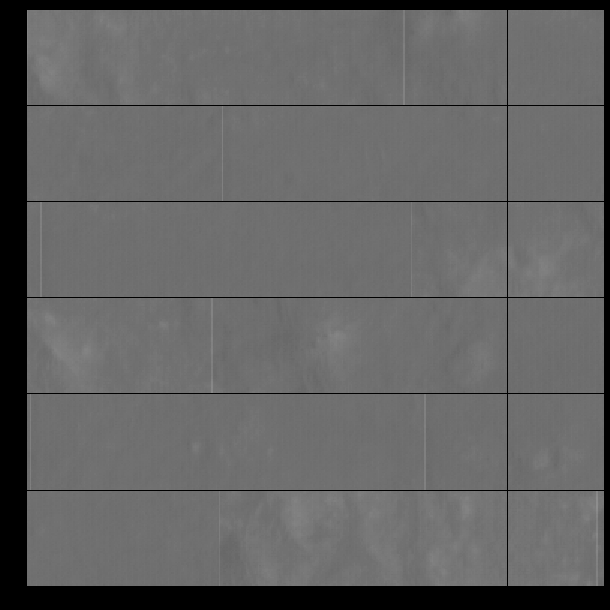

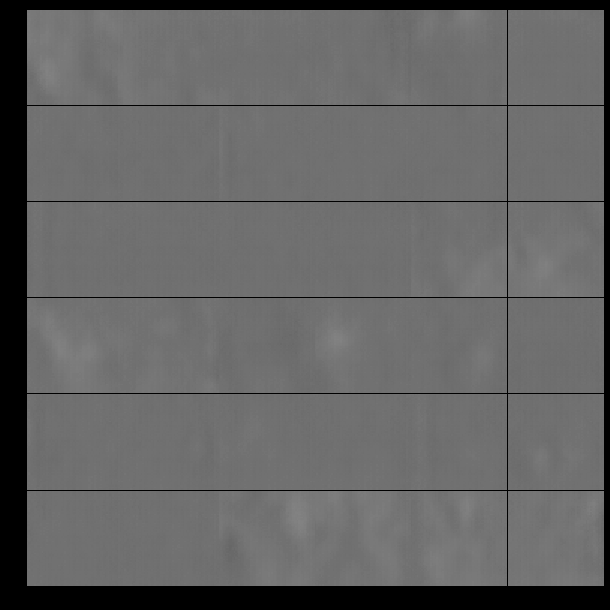

In [15]:
show_img_grid(tensor_images)
predict_and_print(tensor_images[:50])

In [16]:
embeddings, _ = predict(tensor_images[0:1])
np.squeeze(embeddings).shape

(3200,)

In [17]:
import seaborn as sns

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


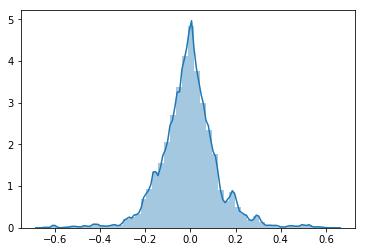

In [18]:
embeddings, _ = predict(tensor_images[0:500])

sns.distplot(np.concatenate(embeddings))

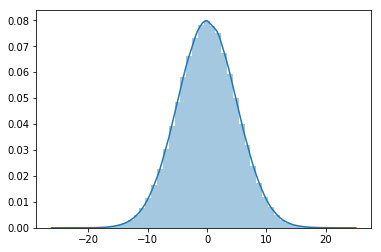

In [19]:
fake_embeddings = torch.randn(batch_size, emb_size) * 5.
sns.distplot(np.concatenate(fake_embeddings.data.cpu().numpy()))
# fake_embeddings

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
subset_size = 100
get_reconstruction_loss = nn.MSELoss()
all_losses = []


def get_subset_loss(images):
    images = shuffle(images)
    
    tensor_images = numpy_images_to_tensor_dataset(images)
    tensor_images = tensor_images / 255
    
    # get random subset
    subset_size = 100
    tensor_images = tensor_images[0:subset_size]
    
    tensor_images = tensor_images.to(device)
    
    embeddings = encoder_net(tensor_images)
    predicted_images = decoder_net(embeddings)
    
    loss = get_reconstruction_loss(tensor_images, predicted_images).item()
    
    return loss
    

for i, img_name in enumerate(red_img_files):    
    patches, ids = extract_patches_from_img(img_name, patch_size=patch_size)
    loss = get_subset_loss(patches)
    
    all_losses.append(NewObj(loss=loss, img_name=img_name))
    
    print(f'file {i + 1}/{len(red_img_files)} loss: {loss:.8f} on image: {img_name}')

file 1/58 loss: 0.00008089 on image: ESP_011286_2200_RED8_0.IMG
file 2/58 loss: 0.00030327 on image: ESP_011283_2265_RED1_1.IMG
file 3/58 loss: 0.00003118 on image: ESP_011335_1005_RED4_0.IMG
file 4/58 loss: 0.00005173 on image: ESP_011261_1960_RED9_1.IMG
file 5/58 loss: 0.00005945 on image: ESP_011261_1960_RED4_0.IMG
file 6/58 loss: 0.00002639 on image: ESP_011314_1585_RED9_0.IMG
file 7/58 loss: 0.00006236 on image: ESP_011261_1960_RED0_0.IMG
file 8/58 loss: 0.00006028 on image: ESP_011261_1960_RED7_0.IMG
file 9/58 loss: 0.00007175 on image: ESP_011264_1090_RED0_0.IMG
file 10/58 loss: 0.00003196 on image: ESP_011327_1980_RED7_0.IMG
file 11/58 loss: 0.00005463 on image: ESP_011261_1960_RED3_0.IMG
file 12/58 loss: 0.00006248 on image: ESP_011261_1960_RED0_1.IMG
file 13/58 loss: 0.00007407 on image: ESP_011264_1090_RED2_0.IMG
file 14/58 loss: 0.00007292 on image: ESP_011264_1090_RED1_0.IMG
file 15/58 loss: 0.00006991 on image: ESP_011261_1960_RED8_0.IMG
file 16/58 loss: 0.00005268 on ima

In [22]:
from operator import attrgetter
losses = list(map(attrgetter('loss'), all_losses))

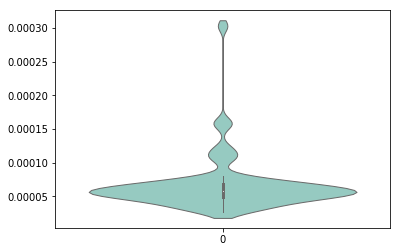

In [23]:
sns.violinplot(data=losses, palette="Set3", bw=.2, cut=1, linewidth=1)

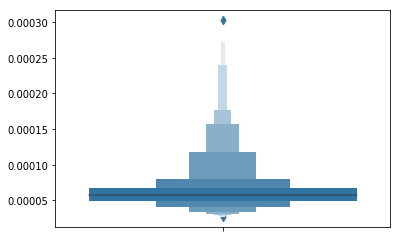

In [24]:
sns.boxenplot(y=losses)

In [25]:
all_losses.sort(key=lambda x: x.loss, reverse=True)

## Looking at files with highest reconstruction loss

In [26]:
images_0, _ = shuffle(*extract_patches_from_img(all_losses[0].img_name, patch_size=patch_size))
images_1, _ = shuffle(*extract_patches_from_img(all_losses[1].img_name, patch_size=patch_size))

In [27]:
current_file_losses_0 = []
for _ in np.arange(10):
    loss = get_subset_loss(images_0)
    current_file_losses_0.append(loss)

current_file_losses_1 = []
for _ in np.arange(10):
    loss = get_subset_loss(images_1)
    current_file_losses_1.append(loss)

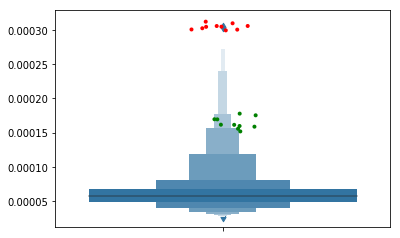

In [28]:
ax = sns.boxenplot(y=losses)
ax = sns.stripplot(y=current_file_losses_0, size=4, jitter=True, color="red")
ax = sns.stripplot(y=current_file_losses_1, size=4, jitter=True, color="green")

In [29]:
tensor_images = numpy_images_to_tensor_dataset(images_0)
tensor_images = tensor_images / 255

### Plot real and reconstructed images

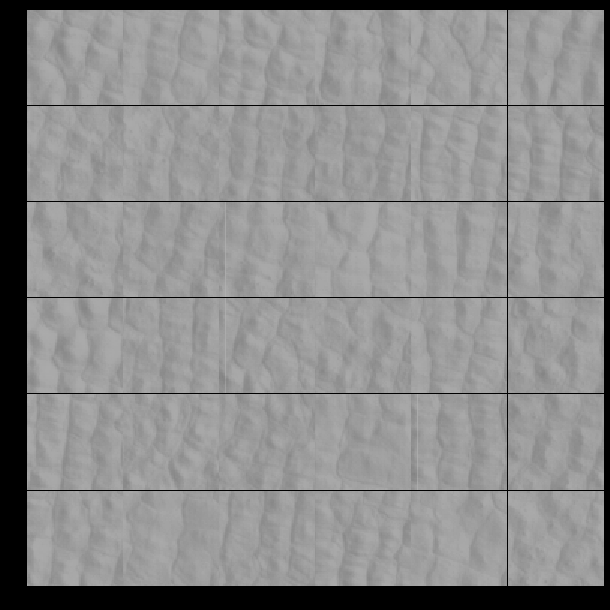

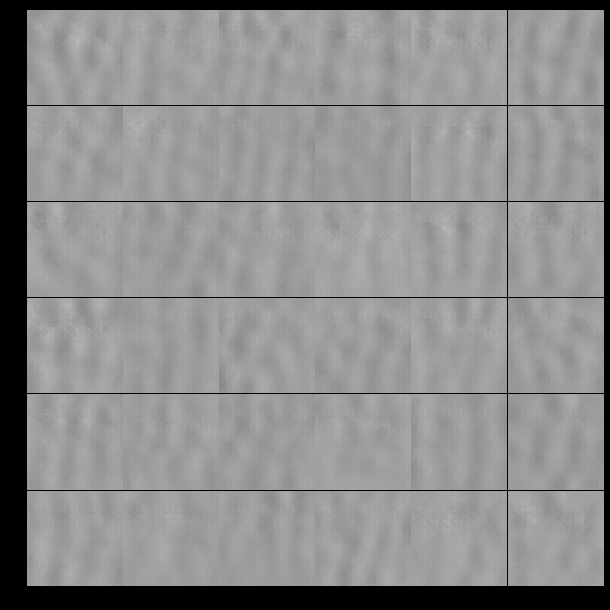

In [30]:
show_img_grid(tensor_images)
predict_and_print(tensor_images[:50])

In [31]:
images, ids = extract_patches_from_img(all_losses[1].img_name, patch_size=patch_size)

tensor_images = numpy_images_to_tensor_dataset(shuffle(images))
tensor_images = tensor_images / 255

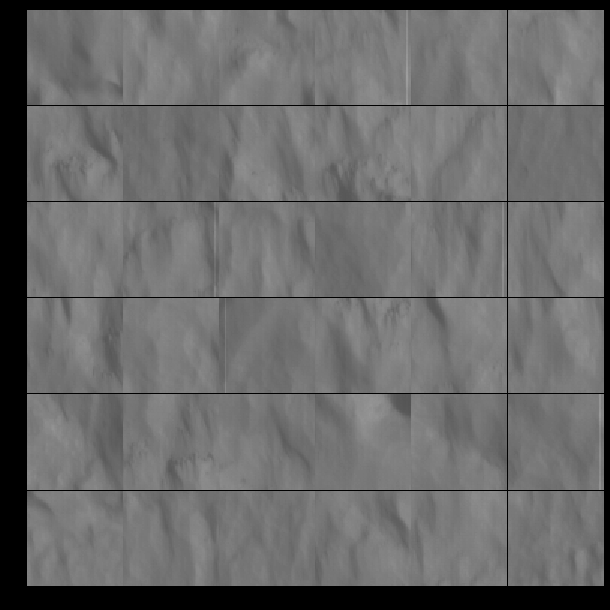

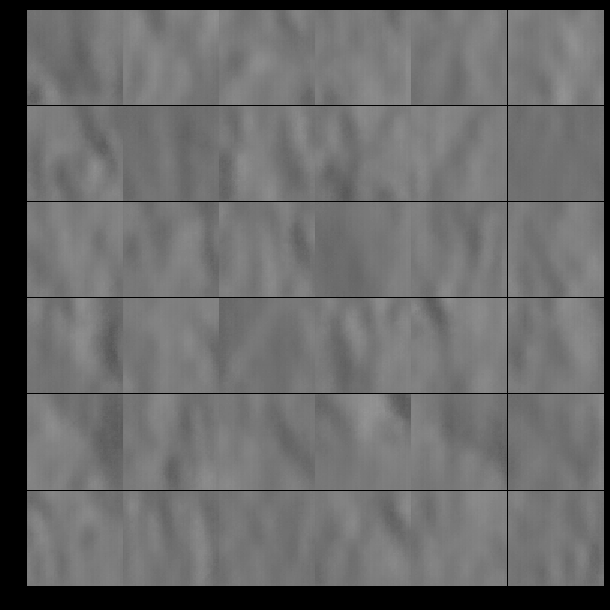

In [32]:
show_img_grid(tensor_images)
predict_and_print(tensor_images[:50])

## Looking at files with lowest reconstruction loss

In [33]:
all_losses.sort(key=lambda x: x.loss, reverse=True)

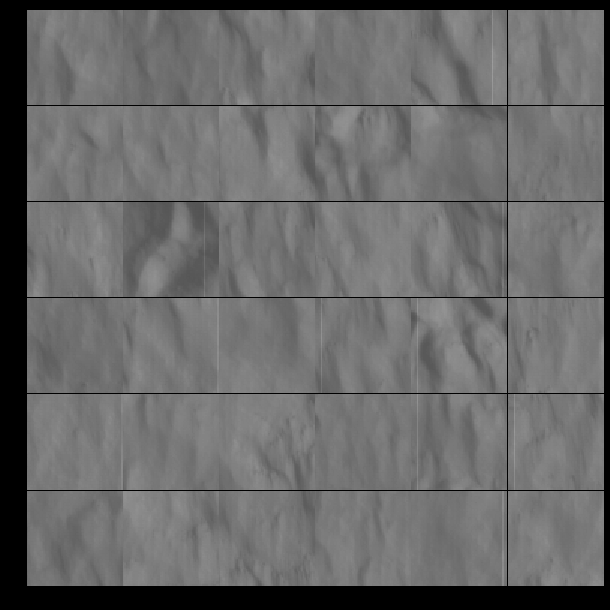

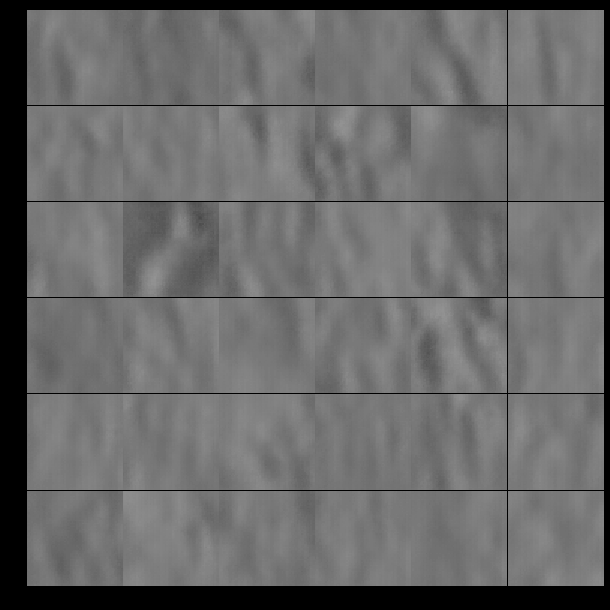

In [34]:
images, ids = extract_patches_from_img(all_losses[1].img_name, patch_size=patch_size)
images, ids = shuffle(images, ids)
    
tensor_images = numpy_images_to_tensor_dataset(images)
tensor_images = tensor_images / 255

show_img_grid(tensor_images)
predict_and_print(tensor_images[:50])